# CMIP6 SST

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import jCMIP as jc
import glob

In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

### Get the model experiments

In [3]:
amocdir = '/home/users/jmecking001/DATADIR/HACKATHON/project04/raw_data/CMIP6/amoc'

In [4]:
# All models with AMOC files:
Files  = glob.glob(amocdir + '*/*/*/*.nc')
allModels = []
for ff in Files:
    allModels.append(ff.split('/')[-1].split('_')[0])
# Remove duplicate names:
allModels = list(set(allModels)) 
# Sort in alphabetical order:
allModels.sort()

print(allModels)

['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR', 'IPSL-CM6A-LR-INCA', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorCPM1', 'SAM0-UNICON', 'TaiESM1', 'UKESM1-0-LL']


In [5]:
Clist = jc.readList('CMIP6list')

In [14]:
model_name = 'ACCESS-CM2'

In [15]:
files = Clist[model_name].getFiles(var='tos', EXP='historical', vtype='Omon', ENS='r1i1p1f1')
files_area = Clist[model_name].getFiles(var='areacello', EXP='historical', ENS='r1i1p1f1')

In [16]:
dset_ACCESS = xr.open_dataset(files[0])
dset_ACCESS_area = xr.open_dataset(files_area[0])

dset_ACCESS = xr.merge([dset_ACCESS, dset_ACCESS_area])

### Calculate the time-series of the annual mean

In [19]:
# amean_tos = ((dset_ACCESS.tos * dset_ACCESS.areacello).sum(dim=['i','j']) / dset_ACCESS.areacello.sum(dim=['i','j'])).groupby('time.year').mean()
amean_tos = ((dset_ACCESS.tos * dset_ACCESS.areacello).sum(axis=(1,2)) / dset_ACCESS.areacello.sum()).groupby('time.year').mean()

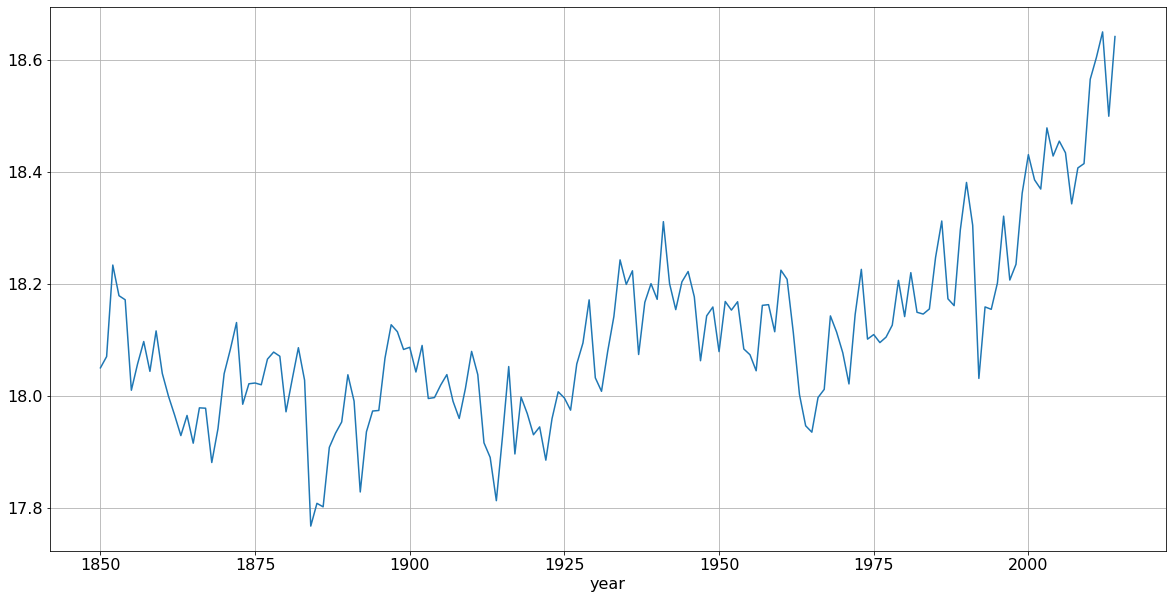

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
amean_tos.plot(ax=ax)
ax.grid(True)

In [35]:
(dset_ACCESS.tos.mean(dim='time') * dset_ACCESS.areacello).sum() / dset_ACCESS.areacello.sum()

<xarray.DataArray ()>
array(18.110752, dtype=float32)

### Now loop through all the models

In [47]:
amean_dset = xr.Dataset()

model_list = []

for ii, model in enumerate(allModels):

    files = Clist[model].getFiles(var='tos', EXP='historical', vtype='Omon', ENS='r1i1p1f1')
    files_area = Clist[model].getFiles(var='areacello')
    
    if (len(files) != 0) & (len(files_area) != 0) & (model[:-4] != 'GFDL'):
        
        dset = xr.open_mfdataset(files)
        dset_area = xr.open_dataset(files_area[0])
        
        dset = xr.merge([dset, dset_area], compat='override')
        dset['areacello'].data[np.isnan(dset.tos.isel(time=0).compute())] = 0
        
        amean_tos = ((dset.tos * dset.areacello).sum(axis=(1,2)) / dset.areacello.sum()).groupby('time.year').mean() 

        amean_dset[model] = amean_tos.compute()

        model_list.append(model)

/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/gws/pw/j05/cop26_hackathons/bristol

In [49]:
amean_dset.to_netcdf('/gws/pw/j05/cop26_hackathons/bristol/project04/amoc_sst/cmip6_historical_annual_mean_tos.nc')

In [56]:
amean_dset

<xarray.Dataset>
Dimensions:            (year: 165)
Coordinates:
  * year               (year) int64 1850 1851 1852 1853 ... 2011 2012 2013 2014
Data variables: (12/31)
    ACCESS-CM2         (year) float32 18.05 18.07 18.23 ... 18.65 18.5 18.64
    ACCESS-ESM1-5      (year) float32 18.66 18.56 18.59 ... 19.19 19.3 19.38
    BCC-CSM2-MR        (year) float32 18.24 18.27 18.32 ... 19.01 19.02 19.04
    BCC-ESM1           (year) float32 18.6 18.58 18.62 ... 19.03 19.11 19.14
    CAMS-CSM1-0        (year) float32 18.09 18.04 18.21 ... 18.58 18.6 18.52
    CESM2              (year) float32 18.34 18.32 18.21 ... 19.09 18.99 18.86
    ...                 ...
    MPI-ESM-1-2-HAM    (year) float32 17.48 17.54 17.55 ... 17.76 17.89 17.91
    MPI-ESM1-2-HR      (year) float32 17.56 17.56 17.72 ... 18.3 18.29 18.28
    MPI-ESM1-2-LR      (year) float32 17.22 17.26 17.29 ... 17.94 17.85 17.85
    MRI-ESM2-0         (year) float32 17.78 17.77 17.74 ... 18.25 18.3 18.24
    NorCPM1            (year) float32 17.19 17.22 17.21 ... 17.83 17.87 17.78
    SAM0-UNICON        (year) float32 17.58 17.66 17.79 ... 18.24 18.21 18.33

Text(0.5, 1.0, 'tos historical Omon r1i1p1f1')

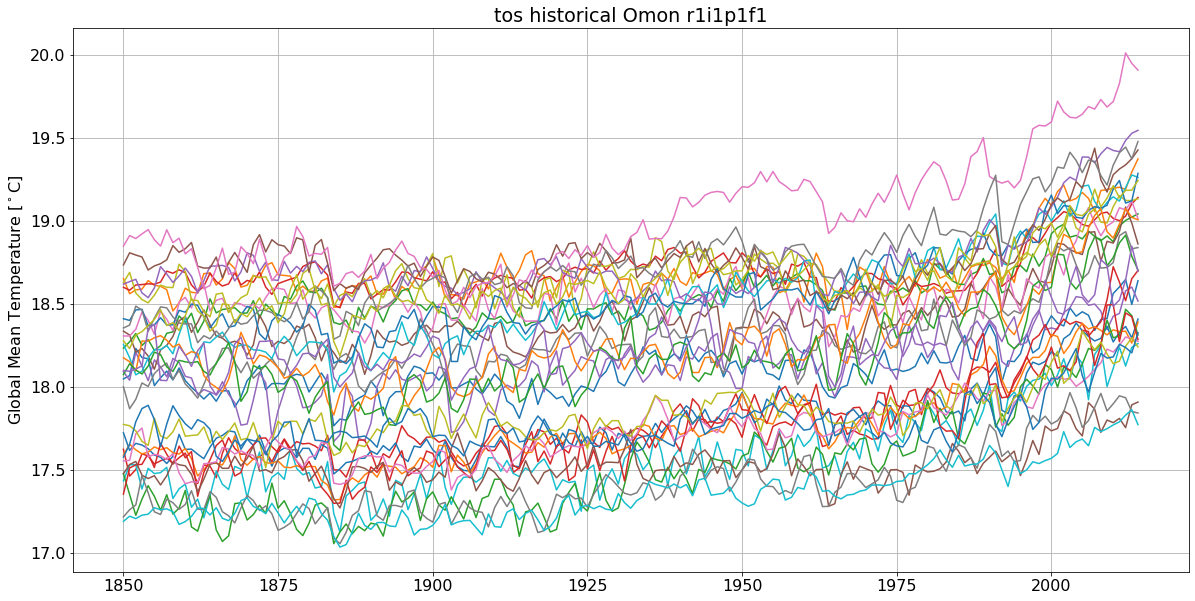

In [58]:
fig, ax = plt.subplots(figsize=(20,10))

for ii, model in enumerate(model_list):
    
    amean_dset[model].plot(ax=ax)

ax.grid(True)
ax.set_ylabel('Global Mean Temperature [$^\circ$C]')
ax.set_xlabel(None)
ax.set_title(('tos' + ' historical' + ' Omon' + ' r1i1p1f1'))

# plt.savefig('/gws/pw/j05/cop26_hackathons/bristol/project04/amoc_sst/cmip6_historical_annual_mean_tos.png', dpi=300, bbox_inches='tight')